# Visualize Neural Network

In [1]:
from torchviz import make_dot
import torch
import torch.nn as nn
from torchvision.models import resnet18
import numpy as np
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt
import hiddenlayer as hl

class SupConModel(nn.Module):
  def __init__(self, feature_dim : int = 128, device : str = "cpu")->None:
    super(SupConModel, self).__init__()
    self.backbone = resnet18(pretrained=True)
    self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.backbone.fc    = nn.Identity()
    self.linear = nn.Linear(512, feature_dim)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, X):
    X = self.encoder(X)
    X = self.softmax(X)

    return X
  
class RegressionModel(torch.nn.Module):
  def __init__(self, supconmodel : SupConModel, features_dim : int = 128, device : str = 'cpu')->None:
    super(RegressionModel, self).__init__()
    self.encoder = supconmodel.encoder

    for param in self.encoder.parameters():
      param.requires_grad = False

    self.head = nn.Sequential (
      nn.Linear(features_dim, features_dim//2),
      nn.ReLU(),
      nn.Linear(features_dim//2, 1),
    ).to(device)

  def forward(self, X):
    with torch.no_grad():
      X = self.encoder(X)
    X = self.head(X)

    return X

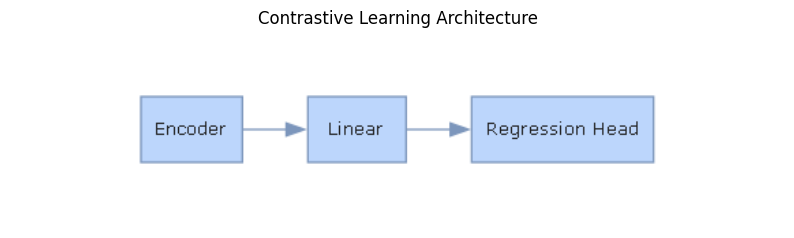

In [ ]:
dummy = torch.randn(1, 1, 126, 126, device="cuda:0", dtype=torch.float32)
enc   = SupConModel(feature_dim=64, device="cuda:0")
head  = RegressionModel(enc, features_dim=64, device="cuda:0")

transforms = [hl.transforms.Prune('Constant'),
              hl.transforms.Fold("Conv > BatchNorm > Relu > MaxPool", "op1", "op1"),
              hl.transforms.Fold("Conv > BatchNorm > Relu > Conv > BatchNorm", "op2", "op2"),
              hl.transforms.Fold("Conv > BatchNorm", "op3", "op3"),
              hl.transforms.Fold("Add > Relu", "op4", "op4"),
              hl.transforms.Fold("GlobalAveragePool > Flatten", "op5", "op5"),
              hl.transforms.Fold("op2 > op4", "op6", "op6"),
              hl.transforms.Fold("op1 > op6 > op6", "op7", "op7"),
              hl.transforms.Fold("op6 > op6", "op8", "op8"),
              hl.transforms.Fold("op3 > op8", "op9", "op9"),
              hl.transforms.Fold("op9 > op9 > op9", "opA", "opA"),
              hl.transforms.Fold("op7 > opA > op5", "resnet18", "Encoder"),
              hl.transforms.Fold("Linear > Relu > Linear", "rhead", "Regression Head"),
              ]
graph = hl.build_graph(head, dummy, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('JUNK/arch.png', format='png')
image = Image.open('JUNK/arch.png')

plt.figure(figsize=[10, 5])
plt.imshow(image, interpolation="bilinear")
plt.axis('off')
plt.title("Neural Network Architecture")
plt.show()


In [3]:
print(head)

RegressionModel(
  (encoder): Sequential(
    (0): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc